<a href="https://colab.research.google.com/github/PabloMorillaCabello/Introduction-to-Artificial-Inteligence/blob/main/Evaluation%20of%20Machine%20Learning%20Regressors%3A%20Implementation%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This step is the first of all the process where we setup some libraries we will use and prepare for importing the data**

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def compare_results(labels, predictions):
    # Create a DataFrame for better visualization
    results_df = pd.DataFrame({
        "Labels": list(labels),
        "Predictions": [f"{p:.1f}" for p in predictions] # Format predictions to one decimal place
    })
    # Transpose the DataFrame for the desired table format (Labels and Predictions as rows)
    results_df = results_df.T

    print("Labels vs Predictions:")
    display(results_df)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# **Skleanr library import**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# **Now we import the data, and stratify it**

In [ ]:
fetch_housing_data()
housing = load_housing_data()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

/tmp/ipython-input-3475643698.py:47: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


# **Since we have categorical and numerical attributes we split them into two variables**

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

In [ ]:
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# **This is the pipeline for numerical values**

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# **Here finally we implement the final pipeline**

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 16)

# **Now lets test some Models**
⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️
#***📏 Linear Regresion 📏***

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# let's try the full preprocessing pipeline on a few training instances
#some_data = housing.iloc[:5]
#some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(housing)
housing_predictions_lin = lin_reg.predict(some_data_prepared)

compare_results(housing_labels, housing_predictions_lin)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE: {lin_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,85657.9,305492.6,152056.5,186095.7,244550.7,206382.4,376422.1,266569.8,151001.8,30119.5,...,220288.0,83083.1,164708.2,304662.9,159339.2,293885.4,81131.3,220683.2,238863.6,98197.8


Linear Regression RMSE: 68627.874


Lets try to make a better precision with cross-validation

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

pd.Series(lin_rmse_scores).describe()

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


,0
count,10.000000
mean,69104.079982
std,3036.132517
min,64114.991664
25%,67077.398482
50%,68718.763507
75%,71357.022543
max,73997.080502


# **🌳 Decision Tree Regressor 🌳**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions_tree = tree_reg.predict(housing_prepared)

compare_results(housing_labels, housing_predictions_tree)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree Regressor RMSE: {tree_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0


Decision Tree Regressor RMSE: 0.000


We have a RMSE = 0 thats not correct, problably overfiting, lets try cross-validation

In [ ]:
tree_reg_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_reg_scores)
display_scores(tree_rmse_scores)

pd.Series(tree_rmse_scores).describe()

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


,0
count,10.000000
mean,71629.890097
std,3071.663088
min,68960.045444
25%,69602.930320
50%,70525.140962
75%,72753.038693
max,79094.741237


# **🌳🎲 Random Forest regressor 🎲🌳**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, forest_reg.predict(housing_prepared))

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f"Random Forest Regressor RMSE: {forest_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,75324.0,302650.0,82760.0,123227.0,228762.0,159980.0,426397.2,325637.0,185844.0,393656.7,...,237538.0,78550.0,92382.0,322218.0,112884.0,280570.0,95098.0,157736.0,236848.0,73571.0


Random Forest Regressor RMSE: 18650.699


It is a good result but lets try to do the cross-validation for better accuracy

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

pd.Series(forest_rmse_scores).describe()

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


,0
count,10.000000
mean,50435.580921
std,2322.522327
min,47210.512698
25%,48682.893887
50%,50812.405036
75%,51872.228024
max,54055.908946


# **🤖📈 Support Vector Machine Regressor 📈🤖**
TEST 1:


In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")


Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,169195.1,195754.5,172636.9,170885.1,187808.2,176324.3,200742.4,189397.8,169589.9,155037.7,...,189845.4,164244.5,176249.1,193288.4,171095.1,194315.6,177085.7,175717.4,182928.6,167728.3


Support Vector Machine Regressor RMSE: 111095.066


In [ ]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T1 = np.sqrt(-svm_scores)
display_scores(svm_scores_T1)
pd.Series(svm_scores_T1).describe()

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.8402690892553


,0
count,10.000000
mean,111814.106926
std,2741.526360
min,106998.562270
25%,110848.005913
50%,112450.979115
75%,113251.558304
max,116063.778167


TEST 2:

In [ ]:
svm_reg = SVR(kernel="rbf")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T2 = np.sqrt(-svm_scores)
display_scores(svm_scores_T2)
pd.Series(svm_scores_T2).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,178735.5,180008.0,178900.9,178924.1,179999.0,179127.4,180409.2,180144.7,178805.4,179064.5,...,179723.3,178497.9,179093.9,180336.6,178896.8,179918.5,179443.5,179218.4,179485.2,178605.7


Support Vector Machine Regressor RMSE: 118578.692
Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean: 118584.55594251942
Standard deviation: 2609.6120823493407


,0
count,10.000000
mean,118584.555943
std,2750.772663
min,113925.043406
25%,117116.931108
50%,119346.990953
75%,120201.617995
max,122785.647373


TEST 3:

In [ ]:
svm_reg = SVR(kernel="poly")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T3 = np.sqrt(-svm_scores)
display_scores(svm_scores_T3)
pd.Series(svm_scores_T3).describe()

TEST 4:

In [188]:
svm_reg = SVR(kernel="sigmoid")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T4 = np.sqrt(-svm_scores)
display_scores(svm_scores_T4)
pd.Series(svm_scores_T4).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,178588.4,180778.0,178806.9,178660.9,180180.0,179069.9,181166.2,180241.4,178524.5,177403.4,...,180393.1,178099.9,179124.2,180536.8,178645.4,180624.7,179306.4,178995.1,179698.2,178431.6


Support Vector Machine Regressor RMSE: 118307.022
Scores: [116525.81742693 119872.51263309 113693.66276272 120133.26245924
 114387.29303067 122528.06824174 119620.71627987 118089.09740371
 120005.97239153 118568.46661355]
Mean: 118342.48692430594
Standard deviation: 2610.3388053925028


,0
count,10.000000
mean,118342.486924
std,2751.538697
min,113693.662763
25%,116916.637421
50%,119094.591447
75%,119972.607452
max,122528.068242


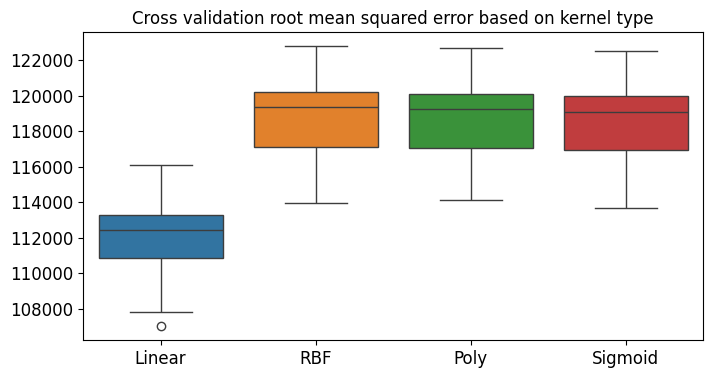

In [192]:
import seaborn as sns

svm_scores_T1.mean
plt.figure(figsize = (8,4))
result_df = pd.DataFrame([svm_scores_T1,svm_scores_T2,svm_scores_T3,svm_scores_T4], ["Linear","RBF","Poly","Sigmoid"],).T
sns.boxplot(data=result_df)
plt.title("Cross validation root mean squared error based on kernel type")
plt.show()

# It seems that the linear is the best of the three for now, lets try to change the value C

Test 1.1: Incresing C value




In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear",C= 10000.0)
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T1_1 = np.sqrt(-svm_scores)
display_scores(svm_scores_T1_1)
pd.Series(svm_scores_T1_1).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,77945.8,301541.7,131714.0,174280.5,227838.8,193386.6,369100.9,248779.3,131409.4,36331.2,...,219234.0,76654.8,152278.9,289680.4,142108.2,281292.9,80794.4,205502.0,228686.1,101972.3


Support Vector Machine Regressor RMSE: 70177.777
Scores: [72594.25749668 66077.21607085 67127.38810235 70239.3677623
 67134.74071207 73922.46981788 77137.8945368  70000.30379852
 67545.14984035 70930.05529475]
Mean: 70270.88434325633
Standard deviation: 3333.6185955727083


,0
count,10.000000
mean,70270.884343
std,3513.942537
min,66077.216071
25%,67237.342994
50%,70119.835780
75%,72178.206946
max,77137.894537


# Ploting and showing cross validation results of the different methods we can see which one is better

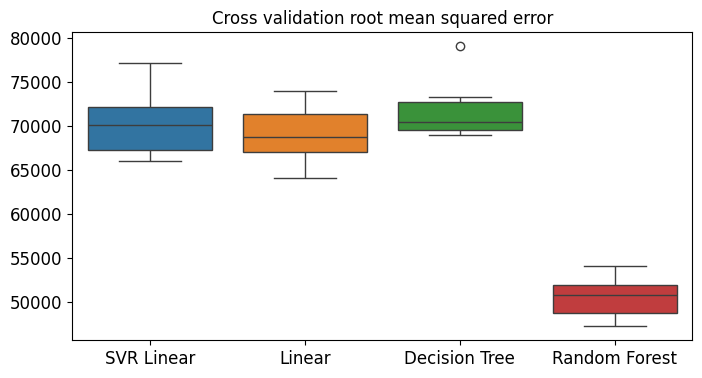

In [193]:

plt.figure(figsize = (8,4))
result_df = pd.DataFrame([svm_scores_T1_1,lin_rmse_scores,tree_rmse_scores,forest_rmse_scores], ["SVR Linear","Linear","Decision Tree","Random Forest"]).T
sns.boxplot(data=result_df)
plt.title("Cross validation root mean squared error")
plt.show()

In [ ]:
# Get the describe outputs for each set of scores
describe_T1 = pd.Series(svm_scores_T1_1).describe()
describe_T2 = pd.Series(lin_rmse_scores).describe()
describe_T3 = pd.Series(tree_rmse_scores).describe()
describe_T4 = pd.Series(forest_rmse_scores).describe()

# Combine the describe outputs into a single DataFrame
# Transpose each describe output so stats are rows and kernels are columns
combined_describe = pd.DataFrame({
    "SVM Linear": describe_T1,
    "Linear regression": describe_T2,
    "Decision Tree": describe_T3,
    "Random Forest": describe_T4
})

display(combined_describe)

,SVM Linear,Linear regression,Decision Tree,Random Forest
count,10.000000,10.000000,10.000000,10.000000
mean,70270.884343,69104.079982,71629.890097,50435.580921
std,3513.942537,3036.132517,3071.663088,2322.522327
min,66077.216071,64114.991664,68960.045444,47210.512698
25%,67237.342994,67077.398482,69602.930320,48682.893887
50%,70119.835780,68718.763507,70525.140962,50812.405036
75%,72178.206946,71357.022543,72753.038693,51872.228024
max,77137.894537,73997.080502,79094.741237,54055.908946
